In [1]:
## Importar librerias necesarias
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

#DIR_DATOS = """C:/Users/w8519/comparison_ped_noped/"""
PARQUET_FILE = """datos_urgencia_consolidados.parquet"""
CSV_OUTPUT_FILE = """datos_urgencia_consolidados_agrupados.csv"""
duckdb.read_parquet(PARQUET_FILE)

def find_peak_week(df, column,window = 5):
    if window % 2 == 0:
        print("please chooose an odd lenght window")
        return
    n = df.shape[0]
    #df_copy = df.copy()
    compare = df[column].drop([k for k in range(window)]).reset_index(drop= True) - df[column].drop([n-window + k for k in range(window)]).reset_index(drop= True)
    compare= compare.reset_index(drop= True)
    return np.argmax(compare)+window //2 

In [2]:
# duckdb.sql("""SELECT distinct 
#            year(strptime(fecha, '%d/%m/%Y')) as year
#            ,IdEstablecimiento
#            ,NEstablecimiento
# FROM datos_urgencia_consolidados.parquet
# where CodigoRegion is null
# -- IdEstablecimiento like '%801'
# order by IdEstablecimiento, year
# """).show(max_rows = 500)

#Identifica los servicios de salud asociados a cada region. Notamos que hay algunas inconsistencias en las referencias.
# duckdb.sql("""SELECT distinct 
#            CodigoRegion             
#            ,CodigoDependencia        
#            ,NombreDependencia        
# FROM datos_urgencia_consolidados.parquet
# -- where CodigoRegion is null
# -- IdEstablecimiento like '%801'
# order by CodigoDependencia
# """).show(max_rows = 500)

In [3]:
#lista todas las columnas del archivo parquet
#duckdb.sql("""describe 
#select * 
#FROM datos_urgencia_consolidados.parquet
#""")
#lista todas las Idcausa con su correspondientes glosa descriptiva
#duckdb.sql("""select distinct IdCausa, GlosaCausa from datos_urgencia_consolidados.parquet
#order by IdCausa""").show(max_rows = 100)

#lista de todos los tipo de establecimientos
#duckdb.sql("""select distinct GLOSATIPOESTABLECIMIENTO from datos_urgencia_consolidados.parquet""").show(max_rows = 100)

In [2]:
#filtra solo las causas asociadas a infecciones respiratorias
df2 = duckdb.sql("""
select fecha
    , CodigoRegion
    , IdCausa
    , GlosaCausa
    , sum(Menores_1) as Menores_1
    , sum(De_1_a_4) as De_1_a_4
    , sum(De_5_a_14) as De_5_a_14
    , sum(De_15_a_64) as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11)
group by fecha, CodigoRegion, IdCausa, GlosaCausa
""").show()
#df2.to_csv(CSV_OUTPUT_FILE,sep=';', date_format='%d/%m/%Y')

┌────────────┬──────────────┬─────────┬──────────────────────┬───┬──────────┬───────────┬────────────┬─────────────┐
│   fecha    │ CodigoRegion │ IdCausa │      GlosaCausa      │ … │ De_1_a_4 │ De_5_a_14 │ De_15_a_64 │ De_65_y_mas │
│  varchar   │    double    │  int64  │       varchar        │   │  int128  │  int128   │   int128   │   int128    │
├────────────┼──────────────┼─────────┼──────────────────────┼───┼──────────┼───────────┼────────────┼─────────────┤
│ 22/07/2018 │         16.0 │      10 │ IRA Alta (J00-J06)   │ … │       71 │        48 │        127 │           8 │
│ 24/07/2018 │         16.0 │      10 │ IRA Alta (J00-J06)   │ … │       54 │        28 │        121 │          10 │
│ 27/07/2018 │         16.0 │      10 │ IRA Alta (J00-J06)   │ … │       38 │        32 │        103 │           8 │
│ 01/08/2018 │         16.0 │      10 │ IRA Alta (J00-J06)   │ … │       31 │        43 │        117 │          11 │
│ 02/08/2018 │         16.0 │      10 │ IRA Alta (J00-J06)   │ …

In [5]:
#filtra los datos asociados a causas respiratorias y agrega columas 
# que indican el año y el número de día correlativo
# adicionalmente se construye la tabla g1 que contiene los datos 
# correspodiente a las atenciones acumuladas del año
# hay un pequeño detalle con los años bisiestos
# esta parte solo funciona para un solo año

df2 = duckdb.sql("""
select
      fecha 
    , year(strptime(fecha, '%d/%m/%Y')) as year
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , sum(Menores_1) as Menores_1
    , sum(De_1_a_4) as De_1_a_4
    , sum(De_5_a_14) as De_5_a_14
    , sum(De_15_a_64) as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11) 
--where IdCausa =6
and fecha like '%2019'
-- and CodigoRegion = 5
group by fecha, year, nrodia
having  nrodia <=365
order by year, nrodia
""").df()
df2['fecha']= pd.to_datetime(df2['fecha'],format='%d/%m/%Y')
df2 = df2.sort_values(by='fecha').reset_index()
g1 = df2[["fecha","year","nrodia","Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]]

g1["acum_Menores_1"]=g1["Menores_1"].cumsum()
g1["acum_Menores_1"]=g1["acum_Menores_1"]/float(g1["acum_Menores_1"][[364]].iloc[0])
g1["acum_De_1_a_4"]=g1["De_1_a_4"].cumsum()
g1["acum_De_1_a_4"]=g1["acum_De_1_a_4"]/float(g1["acum_De_1_a_4"][[364]].iloc[0])
g1["acum_De_5_a_14"]=g1["De_5_a_14"].cumsum()
g1["acum_De_5_a_14"]=g1["acum_De_5_a_14"]/float(g1["acum_De_5_a_14"][[364]].iloc[0])
g1["acum_De_15_a_64"]=g1["De_15_a_64"].cumsum()
g1["acum_De_15_a_64"]=g1["acum_De_15_a_64"]/float(g1["acum_De_15_a_64"][[364]].iloc[0])
g1["acum_De_65_y_mas"]=g1["De_65_y_mas"].cumsum()
g1["acum_De_65_y_mas"]=g1["acum_De_65_y_mas"]/float(g1["acum_De_65_y_mas"][[364]].iloc[0])
g1["uniform"]=np.ones(365).cumsum()
g1["uniform"]=g1["uniform"]/float(g1["uniform"][[364]].iloc[0])

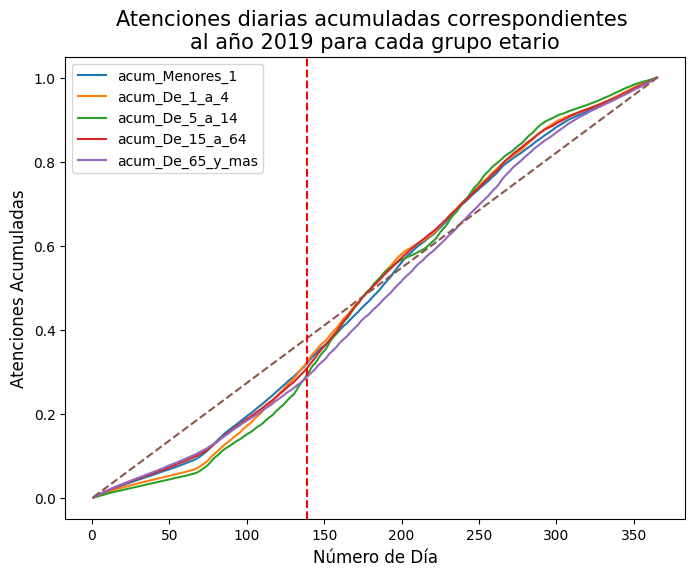

In [6]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
column = "De_1_a_4"
plt.plot(g1["nrodia"],g1[["acum_Menores_1","acum_De_1_a_4","acum_De_5_a_14","acum_De_15_a_64","acum_De_65_y_mas"]],
        label=["acum_Menores_1","acum_De_1_a_4","acum_De_5_a_14","acum_De_15_a_64","acum_De_65_y_mas"])
plt.plot(g1["nrodia"],g1["uniform"], linestyle='dashed')
plt.axvline(x = g1["nrodia"][find_peak_week(g1,"acum_"+column,5)], color='r', linestyle='dashed')
plt.legend();
#plt.plot(g1["fecha"],g1["acum_De_5_a_14"])
#plt.plot(g1["fecha"],g1["acum_De_15_a_64"])
#plt.plot(g1["fecha"],g1["acum_De_65_y_mas"])
ax.set_title('Atenciones diarias acumuladas correspondientes \nal año 2019 para cada grupo etario', fontsize = 15)
ax.set_xlabel('Número de Día', fontsize = 12)
ax.set_ylabel('Atenciones Acumuladas', fontsize = 12)
plt.show()

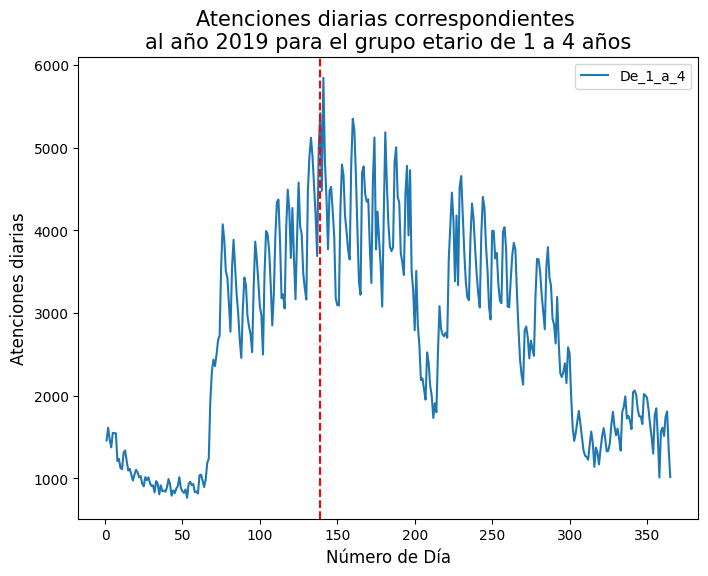

In [7]:
#Datos no acumulados, mostrando la posicion del peak
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
column = "De_1_a_4"
plt.plot(g1["nrodia"],g1[[column]],label=[column])
plt.axvline(x = g1["nrodia"][find_peak_week(g1,"acum_"+column,window = 5)], color='r', linestyle='dashed')
plt.legend();
ax.set_title('Atenciones diarias correspondientes \nal año 2019 para el grupo etario de 1 a 4 años', fontsize = 15)
ax.set_xlabel('Número de Día', fontsize = 12)
ax.set_ylabel('Atenciones diarias', fontsize = 12)
plt.show()

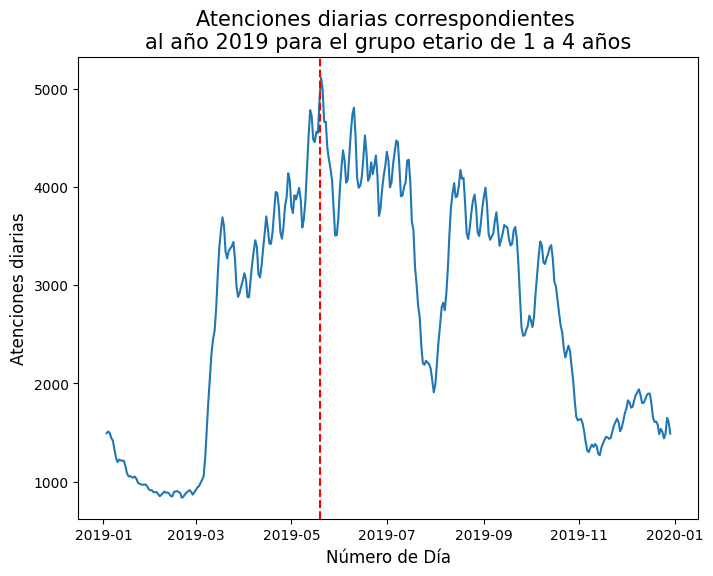

In [8]:
#Promedio móvil de los datos no acumulados, mostrando la posicion del peak
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
df= g1
column = "De_1_a_4"
window = 5
plt.plot(df["fecha"], df[column].rolling(window,center=True).mean())
plt.axvline(x = g1["fecha"][find_peak_week(g1,"acum_"+column,window )], color='r', linestyle='dashed')
ax.set_title('Atenciones diarias correspondientes \nal año 2019 para el grupo etario de 1 a 4 años', fontsize = 15)
ax.set_xlabel('Número de Día', fontsize = 12)
ax.set_ylabel('Atenciones diarias', fontsize = 12)
plt.show()

Text(0, 0.5, 'Atenciones')

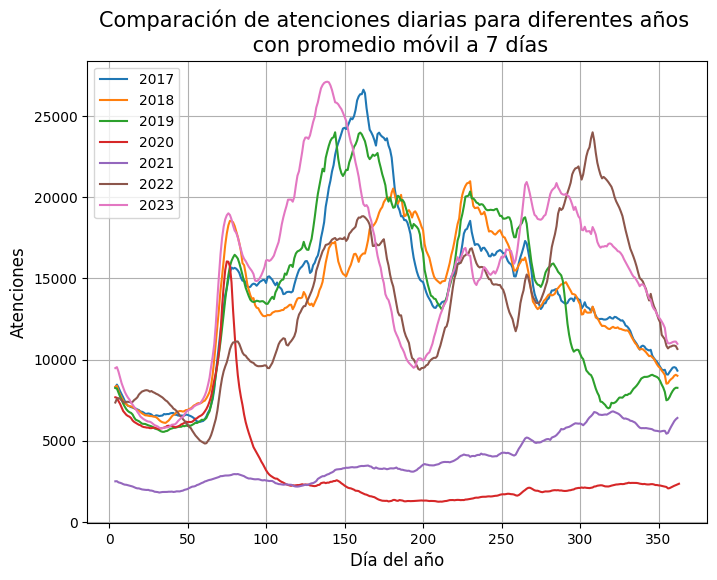

In [9]:
#Full average: Goal to compare populations across years, 
#ages and locations by trying to stablish a baseline reference demand.
#This tries to improve agains using the mean
df3 = duckdb.sql("""
select 
      year(strptime(fecha, '%d/%m/%Y')) as year
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , sum(Menores_1) as Menores_1
    , sum(De_1_a_4) as De_1_a_4
    , sum(De_5_a_14) as De_5_a_14
    , sum(De_15_a_64) as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
    , sum(Menores_1) + sum(De_1_a_4)+ sum(De_5_a_14) + sum(De_15_a_64) + sum(De_65_y_mas) as atenciones
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11) 
--where IdCausa =6 and CodigoRegion = 5
--and fecha like '%2019' 
--and dayofyear(strptime(fecha, '%d/%m/%Y')) <=365
--and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
group by year, nrodia
order by year, nrodia
""").df()
df_dict = {key[0]: d for key, d in df3[['year','nrodia','atenciones']].groupby(['year'])}

# ILUSTRACIÓN 1 ATENCIONES DIARIAS DE URGENCIA PARA CADA DÍA DEL AÑO CORRESPONDIENTES AL PERIODO 2017 -2023 
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
targets = list(df_dict.keys())
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for key in targets:
    plt.plot(df_dict[key]['nrodia'],df_dict[key]['atenciones'].rolling(7,center=True).mean() )
plt.legend(targets)
ax.grid()
ax.set_title('Comparación de atenciones diarias para diferentes años \n con promedio móvil a 7 días', fontsize = 15)
ax.set_xlabel('Día del año', fontsize = 12)
ax.set_ylabel('Atenciones', fontsize = 12)


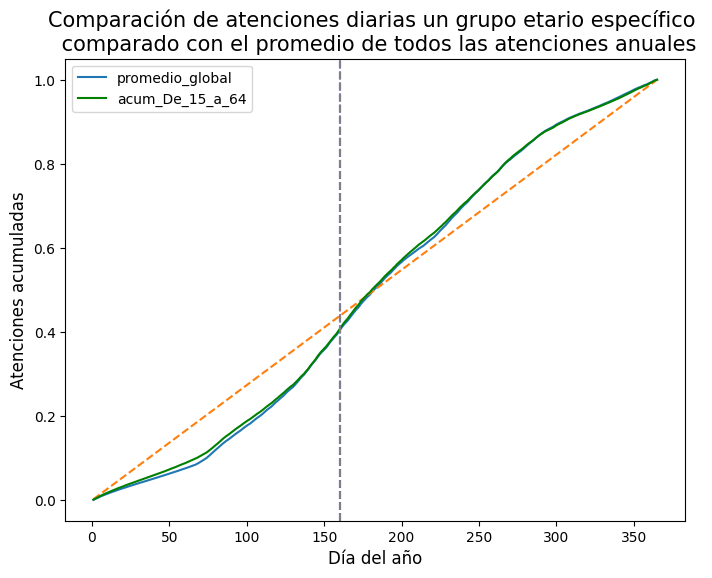

In [10]:
# Comparación de un caso particular vs promedio global

df4 = df_dict[2019].reset_index(drop = True).copy()

df4["acum_atenciones"]=df4["atenciones"].cumsum()
df4["acum_atenciones"]=df4["acum_atenciones"]/float(df4["acum_atenciones"][[364]].iloc[0])
df4["uniform"]=np.ones(365).cumsum()
df4["uniform"]=df4["uniform"]/float(df4["uniform"][[364]].iloc[0])
column = "atenciones"

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
#plt.plot(g1["fecha"],g1["acum_Menores_1"])
plt.plot(df4["nrodia"],df4["acum_"+column], label=["promedio_global"])
plt.plot(df4["nrodia"],df4["uniform"], linestyle='dashed')
plt.axvline(x = df4["nrodia"][find_peak_week(df4,"acum_"+column,5)], color='blue', linestyle='dashed')

#plt.plot(g1["fecha"],g1["acum_De_5_a_14"])
#plt.plot(g1["fecha"],g1["acum_De_15_a_64"])
#plt.plot(g1["fecha"],g1["acum_De_65_y_mas"])
plt.plot(g1["nrodia"],g1["acum_De_15_a_64"],color='g',label = ["acum_De_15_a_64"])
plt.axvline(x = g1["nrodia"][find_peak_week(g1,"acum_De_15_a_64",5)], color='gray', linestyle='dashed')
plt.legend();
ax.set_title('Comparación de atenciones diarias un grupo etario específico \n comparado con el promedio de todos las atenciones anuales', fontsize = 15)
ax.set_xlabel('Día del año', fontsize = 12)
ax.set_ylabel('Atenciones acumuladas', fontsize = 12)
plt.show()

Text(0, 0.5, 'Atenciones')

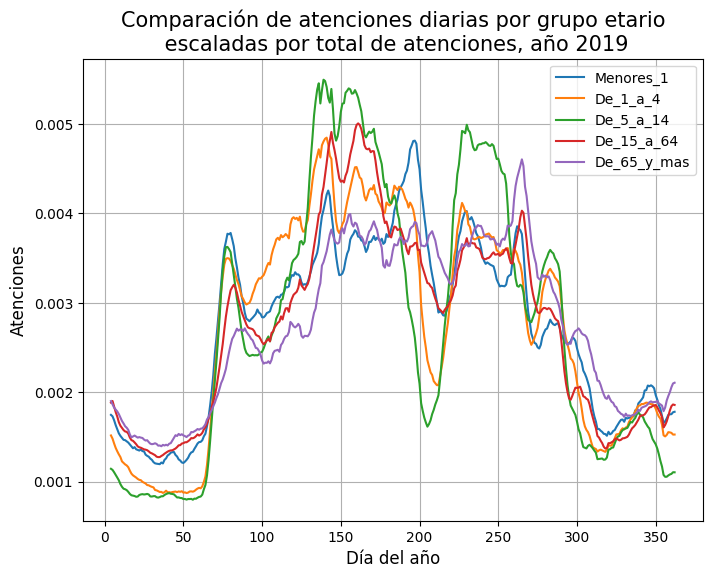

In [11]:
#Comparacion de datos para diferentes grupos etarios para un año fijo
#Full average: Goal to compare populations across years, 
#ages and locations by trying to stablish a baseline reference demand.
#WE scale the data dividing by the total yearly demand in order to distinguish behaviour
df = duckdb.sql("""
select 
      year(strptime(fecha, '%d/%m/%Y')) as year
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , sum(Menores_1) as Menores_1
    , sum(De_1_a_4) as De_1_a_4
    , sum(De_5_a_14) as De_5_a_14
    , sum(De_15_a_64) as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
    , sum(Menores_1) + sum(De_1_a_4)+ sum(De_5_a_14) + sum(De_15_a_64) + sum(De_65_y_mas) as atenciones
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11) 
--where IdCausa =6 and CodigoRegion = 5
and fecha like '%2019' 
--and dayofyear(strptime(fecha, '%d/%m/%Y')) <=365
--and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
group by year, nrodia
order by year, nrodia
""").df()

# ILUSTRACIÓN 1 ATENCIONES DIARIAS DE URGENCIA PARA CADA DÍA DEL AÑO CORRESPONDIENTES AL PERIODO 2017 -2023 
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
targets = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
#colors = ['r', 'g', 'b','orange', 'pink']
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for column in targets:
    plt.plot(df['nrodia'],df[column].rolling(7,center=True).mean()/float(sum(df[column]))) # c = color)
plt.legend(targets)
ax.grid()
ax.set_title('Comparación de atenciones diarias por grupo etario\n escaladas por total de atenciones, año 2019', fontsize = 15)
ax.set_xlabel('Día del año', fontsize = 12)
ax.set_ylabel('Atenciones', fontsize = 12)

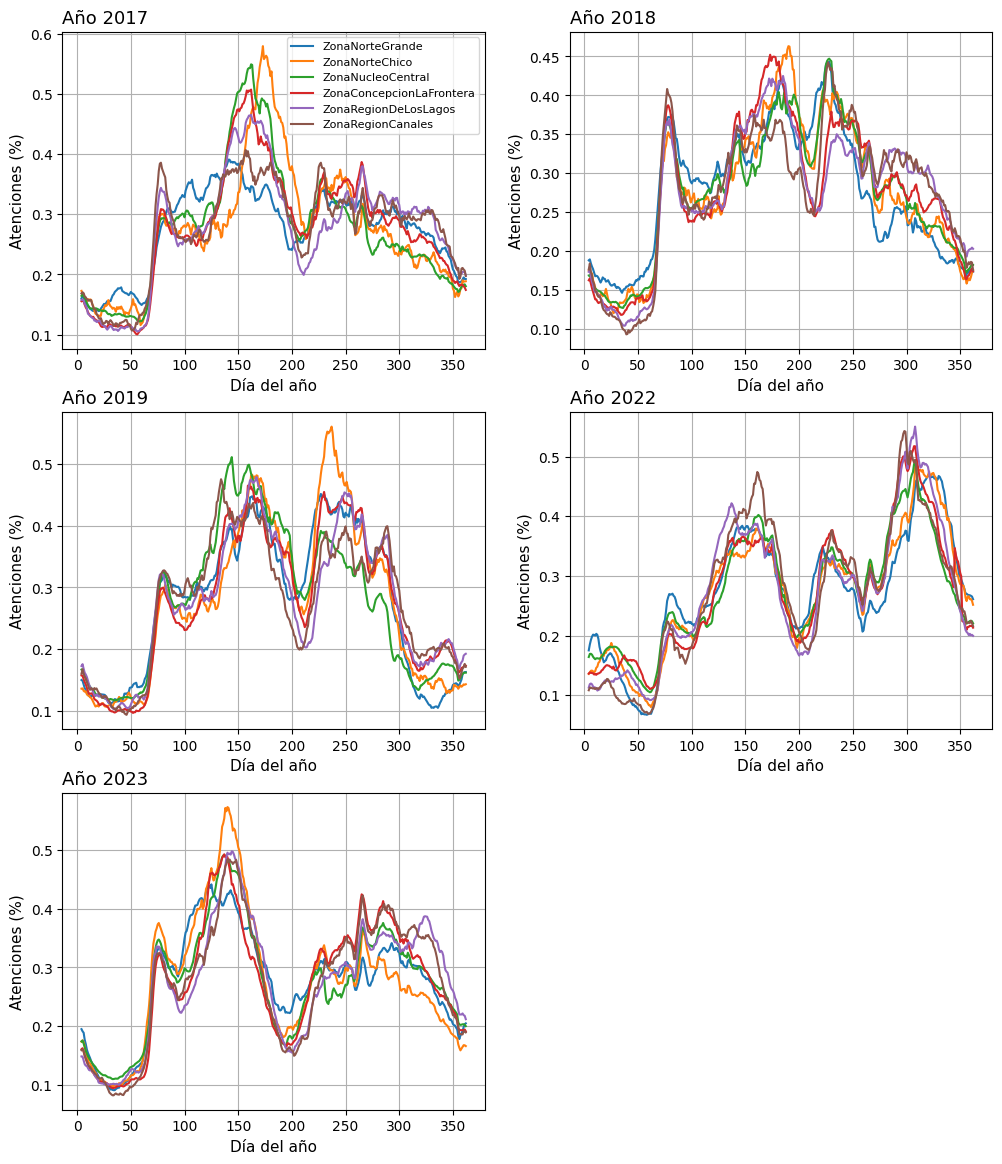

In [19]:
#Genera una comparación de las atenciones diarias correspondiente 
# a diferentes regiones geográficas. Las zonas están determinadas 
# por lo servicios de salud que las componen
# en los gráficos se muestra la información para diferentes años
periodo = 365

zona_norte_grande = """(1,2,3)"""
zona_norte_chico = """(4,5)"""
zona_nucleo_central = """(6,7,8,9,10,11,12,13,14,15,16,17)"""
zona_concepcion_frontera = """(18,19,20,21,28,29)"""
zona_region_de_los_lagos = """(22,23,24)"""
zona_region_canales = """(25,26,33)"""


def common_filter_zona(zona):
    return """
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11)
--and year(strptime(fecha, '%d/%m/%Y')) in (2019)
--and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
--and year(strptime(fecha, '%d/%m/%Y')) in (2022,2023)
and CodigoDependencia in """ + zona +"""
--group by CodigoDependencia, fecha
group by zona, fecha
""" + """
having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(periodo) + """
"""

#here CodigoDependencia indicates the "Servicio de Salud"
#to ignote the grouping by "region"  set "CodigoRegion" to a constant and remove it from the group by
df2 = duckdb.sql("""
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaNorteGrande' as zona
--    , 'Menores_1' as grupo_etario
    , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) + sum(De_15_a_64)  + sum(De_65_y_mas) as atenciones
"""+ common_filter_zona(zona_norte_grande) + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaNorteChico' as zona
--    ,'De_1_a_4' as grupo_etario
    , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) + sum(De_15_a_64)  + sum(De_65_y_mas) as atenciones
"""+ common_filter_zona(zona_norte_chico)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaNucleoCentral' as zona
--    , 'De_5_a_14' as grupo_etario
    , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) + sum(De_15_a_64)  + sum(De_65_y_mas) as atenciones
"""+ common_filter_zona(zona_nucleo_central)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaConcepcionLaFrontera' as zona
--    , 'De_15_a_64'  as grupo_etario
    , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) + sum(De_15_a_64)  + sum(De_65_y_mas) as atenciones
"""+ common_filter_zona(zona_concepcion_frontera)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaRegionDeLosLagos' as zona
--    , 'De_15_a_64'  as grupo_etario
    , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) + sum(De_15_a_64)  + sum(De_65_y_mas) as atenciones
"""+ common_filter_zona(zona_region_de_los_lagos)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaRegionCanales' as zona
--    , 'De_65_y_mas' as grupo_etario
    , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) + sum(De_15_a_64)  + sum(De_65_y_mas) as atenciones
"""+ common_filter_zona(zona_region_canales) + """
""").df()

df2 = df2.sort_values(by=['zona','year','nrodia']).reset_index(drop = True)


# ILUSTRACIÓN 1 ATENCIONES DIARIAS DE URGENCIA PARA 
# CADA DÍA DEL AÑO CORRESPONDIENTES AL PERIODO 2017 -2023 para diferentes zonas geográficas 
fig = plt.figure(figsize = (12,14))
year_list=[2017,2018,2019,2022,2023]

for k in range(5):
    df3 =df2[df2["year"]==year_list[k]]
    ax = fig.add_subplot(3,2,k+1) 
    df_dict = {key[0]: d for key, d in df3[['zona','year','nrodia','atenciones']].groupby(['zona'])}
    #targets = list(df_dict.keys())
    targets = ["ZonaNorteGrande",
               "ZonaNorteChico",
               "ZonaNucleoCentral",
               "ZonaConcepcionLaFrontera",
               "ZonaRegionDeLosLagos",
               "ZonaRegionCanales"]
    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for key in targets:
        plt.plot(df_dict[key]['nrodia'],100*df_dict[key]['atenciones'].rolling(7,center=True).mean()/float(sum(df_dict[key]['atenciones'])) )
    if k==0:
        plt.legend(targets,loc='upper right',fontsize = 8 )
    ax.grid()
    ax.set_title('Año ' + str(year_list[k]) , fontsize = 13, loc='left')
    ax.set_xlabel('Día del año', fontsize = 11)
    ax.set_ylabel('Atenciones (%)', fontsize = 11)





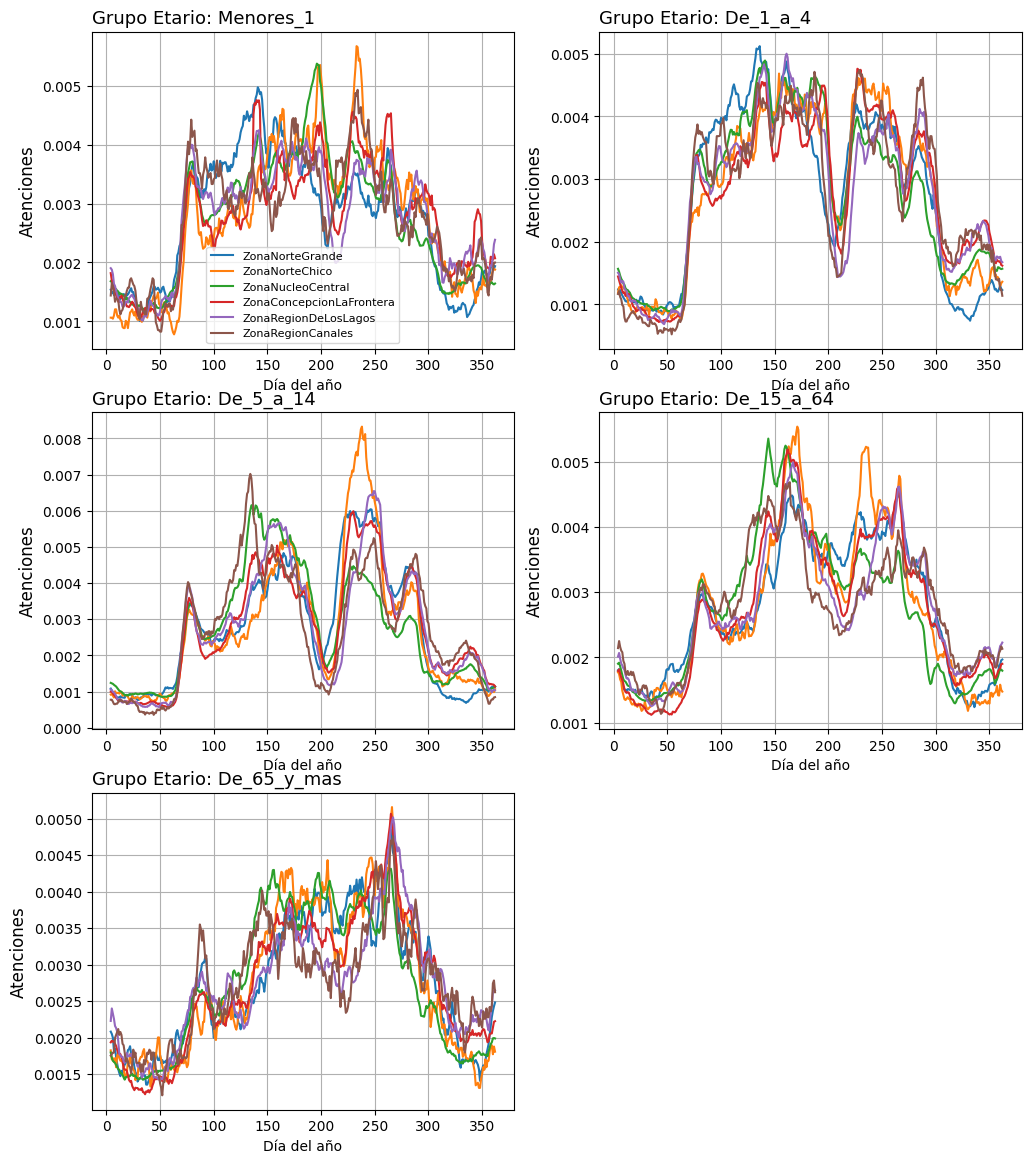

In [28]:
#Genera una comparación de las atenciones diarias correspondiente 
# a diferentes regiones geográficas. Las zonas están determinadas 
# por lo servicios de salud que las componen
# en los gráficos se muestra la información para diferentes grupos etarios
periodo = 365

zona_norte_grande = """(1,2,3)"""
zona_norte_chico = """(4,5)"""
zona_nucleo_central = """(6,7,8,9,10,11,12,13,14,15,16,17)"""
zona_concepcion_frontera = """(18,19,20,21,28,29)"""
zona_region_de_los_lagos = """(22,23,24)"""
zona_region_canales = """(25,26,33)"""


def common_filter_zona(zona):
    return """
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11)
and year(strptime(fecha, '%d/%m/%Y')) in (2019)
--and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
--and year(strptime(fecha, '%d/%m/%Y')) in (2022,2023)
and CodigoDependencia in """ + zona +"""
--group by CodigoDependencia, fecha
group by zona, fecha
""" + """
having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(periodo) + """
"""

#here CodigoDependencia indicates the "Servicio de Salud"
#to ignote the grouping by "region"  set "CodigoRegion" to a constant and remove it from the group by
df2 = duckdb.sql("""
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaNorteGrande' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(zona_norte_grande) + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaNorteChico' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(zona_norte_chico)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaNucleoCentral' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(zona_nucleo_central)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaConcepcionLaFrontera' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(zona_concepcion_frontera)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaRegionDeLosLagos' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(zona_region_de_los_lagos)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaRegionCanales' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(zona_region_canales) + """
""").df()

df2 = df2.sort_values(by=['zona','year','nrodia']).reset_index(drop = True)
df3 = pd.concat([df2[["zona","year","nrodia","Menores_1"]].rename(columns={"Menores_1":"atenciones"}).assign(grupo_etario = "Menores_1"),
df2[["zona","year","nrodia","De_1_a_4"]].rename(columns={"De_1_a_4":"atenciones"}).assign(grupo_etario = "De_1_a_4"),
df2[["zona","year","nrodia","De_5_a_14"]].rename(columns={"De_5_a_14":"atenciones"}).assign(grupo_etario = "De_5_a_14"),
df2[["zona","year","nrodia","De_15_a_64"]].rename(columns={"De_15_a_64":"atenciones"}).assign(grupo_etario = "De_15_a_64"),
df2[["zona","year","nrodia","De_65_y_mas"]].rename(columns={"De_65_y_mas":"atenciones"}).assign(grupo_etario = "De_65_y_mas")
])

# ILUSTRACIÓN 1 ATENCIONES DIARIAS DE URGENCIA PARA 
# CADA DÍA DEL AÑO CORRESPONDIENTES AL PERIODO 2017 -2023 para diferentes zonas geográficas 
fig = plt.figure(figsize = (12,14))
grupo_etario_list=["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]

for k in range(5):
    df4 =df3[df3["grupo_etario"]==grupo_etario_list[k]]
    ax = fig.add_subplot(3,2,k+1) 
    df_dict = {key[0]: d for key, d in df4[['zona','year','nrodia','atenciones']].groupby(['zona'])}
    #targets = list(df_dict.keys())
    targets = ["ZonaNorteGrande",
               "ZonaNorteChico",
               "ZonaNucleoCentral",
               "ZonaConcepcionLaFrontera",
               "ZonaRegionDeLosLagos",
               "ZonaRegionCanales"]
    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for key in targets:
        plt.plot(df_dict[key]['nrodia'],df_dict[key]['atenciones'].rolling(7,center=True).mean()/float(sum(df_dict[key]['atenciones'])) )
    if k==0:
        plt.legend(targets,loc='lower center',fontsize = 8 )
        #plt.legend(targets,loc='upper right',fontsize = 8 )
    ax.grid()
    ax.set_title('Grupo Etario: ' + str(grupo_etario_list[k]) , fontsize = 13, loc='left')
    ax.set_xlabel('Día del año', fontsize = 10)
    ax.set_ylabel('Atenciones', fontsize = 12)



In [14]:
df2[["zona","year","nrodia","Menores_1"]].rename(columns={"Menores_1":"atenciones"})


,zona,year,nrodia,atenciones
0,ZonaConcepcionLaFrontera,2019,1,87.0
1,ZonaConcepcionLaFrontera,2019,2,73.0
2,ZonaConcepcionLaFrontera,2019,3,75.0
3,ZonaConcepcionLaFrontera,2019,4,73.0
4,ZonaConcepcionLaFrontera,2019,5,94.0
...,...,...,...,...
2185,ZonaRegionDeLosLagos,2019,361,44.0
2186,ZonaRegionDeLosLagos,2019,362,44.0
2187,ZonaRegionDeLosLagos,2019,363,66.0
2188,ZonaRegionDeLosLagos,2019,364,60.0
